### Building a Tree Code I:  Introduction to the Barnes-Hut Algorithm

In the next series of notebooks we will explore some ingredients for building an efficient N-Body code. These will in large part be less-numerical algorithms like ways for sorting and effciently accessing multidimensional data, in our case particle data.

First, let's examine what we need for an N-Body algorithm designed for large $N$. Usually, such a calculation has two parts: finding the acceleration and advancing the system of ODE's.
The second part is easy; each particle obeys a separate second-order ODE. Particles "talk" to each other is through the acceleration, and this makes the first part more complex.

We have already considered the particle-mesh technique:
   1. Particles' charge is distributed into the cells of a regular grid.
   2. Poisson's equation is solved on the grid to obtain the potential, using either Fourier or Multigrid techniques.
   3. The potential on the grid is finite-differenced to obtain the acceleration.
   4. The acceleration is interpolated to the particle positions.
   
The problem with this technique for many astrophysical N-body calculations is that, gravity being an attractive force, particles tend to cluster, and we often need to calculate the acceleration within a cluster (galaxies, anyone?). Using particle-mesh, the acceleration between particles within the same grid cell tends to zero. To provide the needed resolution, we will need an impossibly large grid. One can employ adaptive grids, but even an adaptive grid would need to have a sufficient number of cells to allow two-body orbits wherever they occur. Suddenly, we have more cells than particles!

Instead of solving for the potential on a grid, many gravitational N-body codes determine the acceleration directly from the particle positions
$$ \mathbf{a}_i = -G \sum_{\substack{j=1\\j\ne i}}^N \frac{m_j}{|\mathbf{r}_i-\mathbf{r}_j|^3}(\mathbf{r}_i-\mathbf{r}_j)$$
Since there are $N$ particles and $N-1$ terms in each sum, this is an $O(N^2)$ algorithm.
We need an algorithm with better scaling...

We can reduce the number of terms in the sum by employing a multipole expansion of the charge (mass) distribution. 

Consider a Taylor expansion of the potential at $\mathbf{r}$ due to a charge at $\mathbf{r}_0$:
$$ \phi(\mathbf{r}) = \frac{1}{|\mathbf{r} - \mathbf{r}_0|} $$
We can write a multidimensional Taylor expansion by noticing that
$$ e^{\mathbf{a}\cdot\nabla} = \sum_{n=0}^\infty \frac{1}{n!}(\mathbf{a}\cdot\nabla)^n$$
This is an operator which translates the argument of the function to which it is applied a distance $\mathbf{a}$ away:

\begin{align} f(\mathbf{x} + \mathbf{a}) &= e^{\mathbf{a}\cdot\nabla} f(\mathbf{x}) \\
&= f(\mathbf{x}) + (\mathbf{a}\cdot\nabla)f(x) + \frac{1}{2}(\mathbf{a}\cdot\nabla)(\mathbf{a}\cdot\nabla) f(x) + \cdots
\end{align}
and thus
\begin{align} f(\mathbf{x}) &= e^{(\mathbf{x}-\mathbf{a})\cdot\nabla} f(\mathbf{x}) \\
&= f(\mathbf{a}) + ((\mathbf{x}-\mathbf{a})\cdot\nabla)f(\mathbf{a}) + \frac{1}{2}
((\mathbf{x}-\mathbf{a})\cdot\nabla)((\mathbf{x}-\mathbf{a})\cdot\nabla)f(\mathbf{a}) + \cdots
\end{align}
Expanding out the divergences in terms of sum of indices, the operators in the first three terms are
\begin{align}
(\mathbf{a}\cdot\nabla) &= \sum_{i=1}^3 a_i\frac{\partial}{\partial x_i}\\
(\mathbf{a}\cdot\nabla)(\mathbf{a}\cdot\nabla) &= \sum_{ij} a_i a_j \frac{\partial^2}{\partial x_i \partial x_j}
\end{align}

We can use this to expand the potential at $\mathbf{r}$ due to a point $\mathbf{r}^\prime$ with respect to an origin at $\mathbf{r}_0$ as
\begin{align}
\frac{1}{|\mathbf{r}-\mathbf{r}^\prime|} &= \frac{1}{|(\mathbf{r}-\mathbf{r}_0)-(\mathbf{r}^\prime-\mathbf{r}_))|} \\
&= \frac{1}{|\mathbf{r}-\mathbf{r}_0|} + 
\frac{(\mathbf{r}^\prime-\mathbf{r}_0)\cdot(\mathbf{r}-\mathbf{r}_0)}{|\mathbf{r}-\mathbf{r}_0|^3} \\
&+ \frac{1}{2}\sum_{ij}\frac{(r_i-r_{0i})(r_j-r_{0j})}{|\mathbf{r}-\mathbf{r}_0|^5}\left[3(r^\prime_i-r_{0i})(r^\prime_j-r_{0j}) - |\mathbf{r}^\prime-\mathbf{r}_0|^2\delta_{ij}\right] + \cdots
\end{align}

Using this, we can write the potential at $\phi(\mathbf{r})$ due to a collection of $M$ particles at $\mathbf{r}_k$
$$ \phi(\mathbf{r}) = \sum_{k=1}^M \frac{m_k}{|\mathbf{r}-\mathbf{r}_k|} $$
as a Tayor expansion about the point $\mathbf{r}_0$ as
\begin{align}
\phi(\mathbf{r}) &= \left(\sum_k m_k\right)\frac{1}{|\mathbf{r}-\mathbf{r}_0|} \\
&+ \left(\sum_k \frac{m_k (\mathbf{r}_k-\mathbf{r}_0)}{|\mathbf{r}-\mathbf{r}_0|^3}\right)\cdot \frac{(\mathbf{r}-\mathbf{r}_0)}{|\mathbf{r}-\mathbf{r}_0|^3} +\\
&+\frac{1}{2}\sum_{ij}\left(\sum_k m_k\left[3(r^\prime_i-r_{0i})(r^\prime_j-r_{0j}) - |\mathbf{r}^\prime-\mathbf{r}_0|^2\delta_{ij}\right]\right) \frac{(r_i-r_{0i})(r_j-r_{0j})}{|\mathbf{r}-\mathbf{r}_0|^5} + \cdots
\end{align}

The terms in large parentheses, which depend only upon the $\mathbf{r}_k$ and $\mathbf{r}_0$ are the *multipole moments* of the distribution or the $\mathbf{r}_k$ computed with respect to the origin $\mathbf{r}_0$. The first is the monopole moment, just the total mass of the $M$ points, the second is the dipole moment, and the third the quadrupole. If we choose the point $\mathbf{r}_0$ to be the center of mass of the $M$ points, the dipole moment vanishes (for gravity, with only one sign of charge), so the first two non-zero terms in our expansion become the monopole and quadrupole.

Now we get to reduce the number of terms in our acceleration sum. Consider the acceleration of particle $i$ due to all of the other $N-1$ bodies. We can take a subset of $M$ of these $N-1$ bodies and replace them by a Taylor expansion. If we choose to take only the monopole term, we are in effect replacing the $M$ terms in the sum by a single term of the same form, where the position is the center of mass of the $M$ particles and the mass is the sum of the $M$ masses. Effectively, we replace $M$ particles with one big particle. If we wish for more accuracy, we can always replace a group with an approximation up to higher-order terms (quadrupole or greater). In practice, most people use only the monopole expansion.

If we select many of these groups, we can substantially reduce the number of terms. We now have two problems to address: How do we select these groups, and how do we select them with little enough work that we actually speed up our algorithm over the direct sum.

The answer to the first question is one of accuracy. The expansion is only an approximation, and we don't want to sacrifice too much accuracy for speed.

NBody practitioners often speak of the particle $i$ at which we wish to determine the acceleration as the *sink* particle, making the $N-1$ other particles the *sources* of its acceleration. Imagine we have the following geometry where the sink particle is in red and a group of source particles are in blue. The center of mass of the group of sources is the big particle in green. The distace between the sink particle and the center of mass is 
$R_{com} = |\mathbf{r}_i-\mathbf{r}_0|$ and the radius of the sphere about the center of mass just enclosing all of the particles is $B_{max}$. (Ignore the square for now.)

<div>
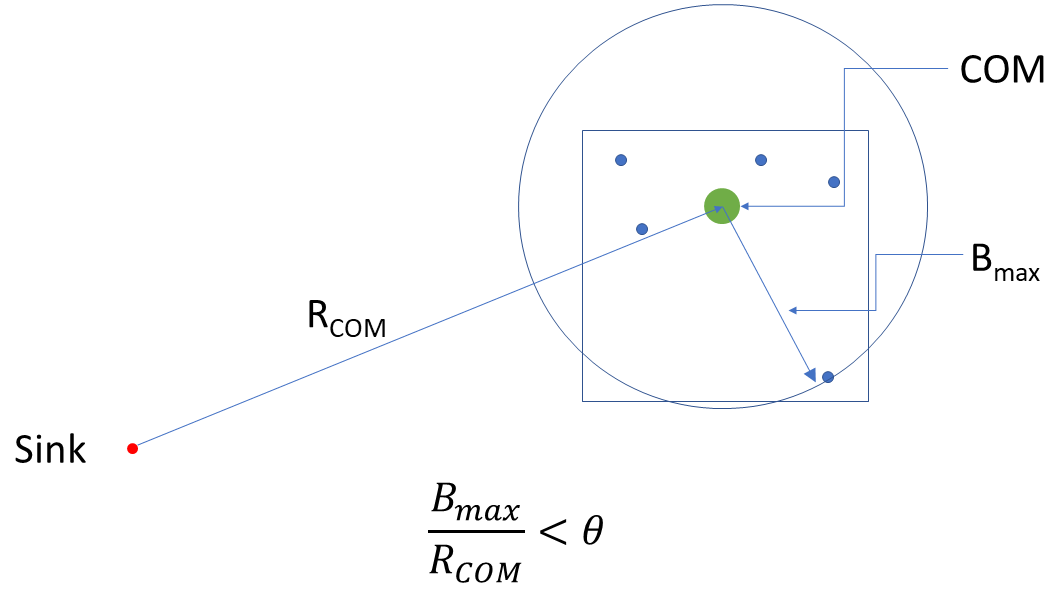
</div>

Our Taylor expansion is in $1/|\mathbf{r}_i-\mathbf{r}_k)|$, so as the sink particles in the group become more distant, our Taylor expansion will become more accurate. A convenient way to parameterize choosing groups leading to a given accuracy is to require that
$\frac{B_{max}}{R_{com}} < \theta$; we can tune the value of $\theta$ to achieve the accuracy we require in any given calculation.

Clearly, if $\theta=0$ we will not be able to find any groups, and we are back to $O(N^2)$. For $\theta>1$, we can put *all* of the particles in a single group, and have no accuracy at all, but marvelous speed!

Our second question was: how do we find suitable groups quickly? One algorithm for doing so was developed by Josh Barnes and Piet Hut and is now known as the Barnes-Hut algorithm: *A Hierarchical O(N log N) Force-calculation Algorithm*, 1986 Nature 324, p. 446.

In the next few notebooks we will develop an implementation of Barnes-Hut.